In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score

In [31]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# DataSet

In [32]:
# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length=4):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx+self.seq_length].values
        y = self.data[self.target_col].iloc[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Mode

In [33]:

class GLU(nn.Module):
    def __init__(self, input_size, output_size):
        super(GLU, self).__init__()
        self.fc = nn.Linear(input_size, 2 * output_size)

    def forward(self, x):
        x_proj = self.fc(x)
        return x_proj[:, :, :x_proj.size(2) // 2] * torch.sigmoid(x_proj[:, :, x_proj.size(2) // 2:])

class TimeDistributed(nn.Module):
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):
        batch_size, timesteps, input_size = x.size()
        x = x.contiguous().view(batch_size * timesteps, input_size)
        y = self.module(x)
        return y.view(batch_size, timesteps, y.size(1))

class TFT(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_attention_heads=4, dropout=0.1):
        super(TFT, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_attention_heads, dropout=dropout, batch_first=True)
        
        self.glu = GLU(hidden_size, hidden_size)
        
        self.positionwise_ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.time_distributed = TimeDistributed(nn.Linear(hidden_size, output_size))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        
    def forward(self, x, future_inputs=None):
        # LSTM for temporal dependencies
        lstm_out, _ = self.lstm(x)
        
        # Multihead Attention
        attn_output, _ = self.multihead_attn(lstm_out, lstm_out, lstm_out)
        
        # Apply GLU to attention output
        glu_output = self.glu(attn_output)
        
        # Position-wise feed-forward network
        ffn_output = self.positionwise_ffn(glu_output)
        
        # Residual connection and layer normalization
        output = self.layer_norm(lstm_out + ffn_output)
        
        # Final prediction through TimeDistributed layer
        output = self.time_distributed(output)
        
        return output

In [34]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')

In [35]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)

In [52]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [53]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Task1: Predict the heating_15min_diff using the weather data

## Using the weather data as features

In [37]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [38]:
batch_size = 32
input_size =  len(input_cols)  # Input feature dimension
hidden_size = 64  # LSTM hidden layer dimension
output_size = 1  # Output dimension
num_attention_heads = 4  # Number of attention heads
    
# Instantiate the model
model = TFT(input_size, hidden_size, output_size, num_attention_heads).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [40]:
train_losses = []
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        
        outputs = outputs[:, -1, :]
        
        # Reshape targets to match the output shape
        targets = targets.unsqueeze(-1)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss: {avg_epoch_loss:.4f}')


Epoch [1/100], avg_epoch_mse_loss: 3.1131
Epoch [2/100], avg_epoch_mse_loss: 2.4173
Epoch [3/100], avg_epoch_mse_loss: 2.3253
Epoch [4/100], avg_epoch_mse_loss: 2.2537
Epoch [5/100], avg_epoch_mse_loss: 2.2460
Epoch [6/100], avg_epoch_mse_loss: 2.1739
Epoch [7/100], avg_epoch_mse_loss: 2.1500
Epoch [8/100], avg_epoch_mse_loss: 2.1457
Epoch [9/100], avg_epoch_mse_loss: 2.1116
Epoch [10/100], avg_epoch_mse_loss: 2.0903
Epoch [11/100], avg_epoch_mse_loss: 2.0869
Epoch [12/100], avg_epoch_mse_loss: 2.0758
Epoch [13/100], avg_epoch_mse_loss: 2.0561
Epoch [14/100], avg_epoch_mse_loss: 2.0483
Epoch [15/100], avg_epoch_mse_loss: 1.9954
Epoch [16/100], avg_epoch_mse_loss: 2.0242
Epoch [17/100], avg_epoch_mse_loss: 2.0249
Epoch [18/100], avg_epoch_mse_loss: 1.9911
Epoch [19/100], avg_epoch_mse_loss: 2.0027
Epoch [20/100], avg_epoch_mse_loss: 1.9798
Epoch [21/100], avg_epoch_mse_loss: 1.9869
Epoch [22/100], avg_epoch_mse_loss: 1.9629
Epoch [23/100], avg_epoch_mse_loss: 1.9636
Epoch [24/100], avg_

In [42]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs).to(device)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test  mse Loss: 3.5069
Test RSME Loss: 1.8727
Test MAE: 1.4550
Test R² Score: 0.2751


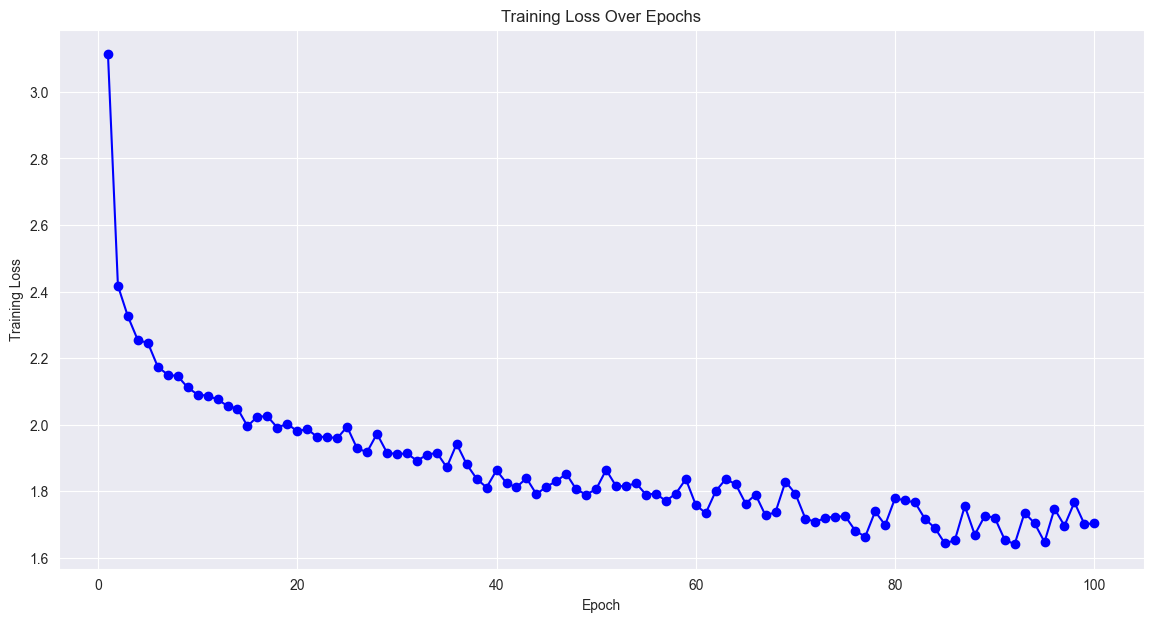

In [43]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

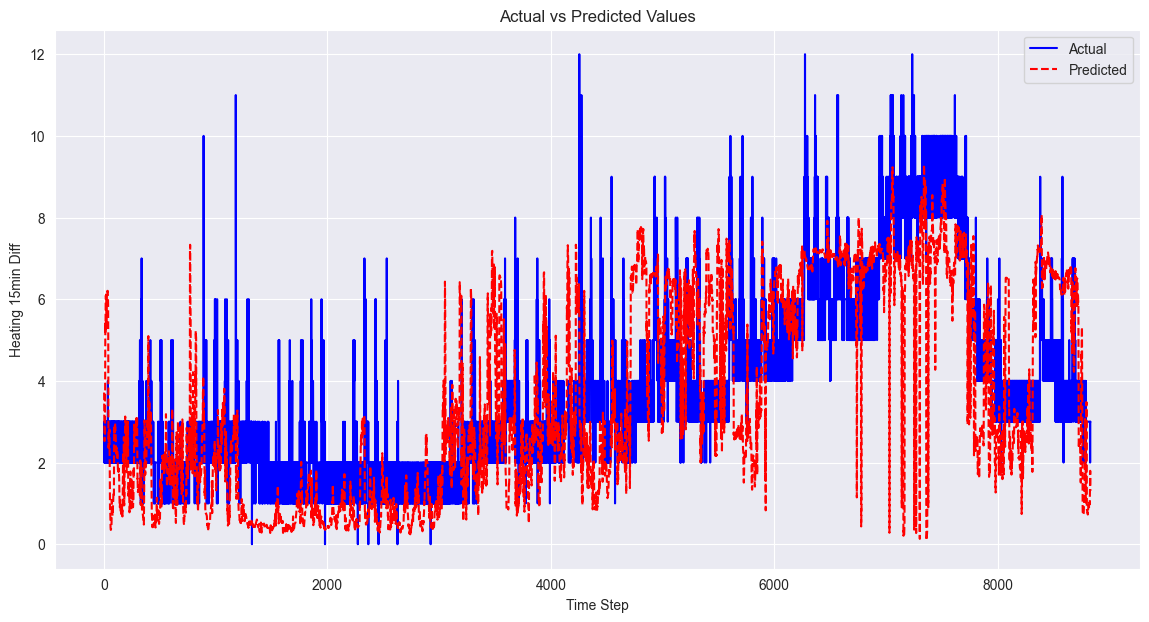

In [44]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Using data with holidays

In [54]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [55]:
batch_size = 32
input_size =  len(input_cols)  # Input feature dimension
hidden_size = 64  # LSTM hidden layer dimension
output_size = 1  # Output dimension
num_attention_heads = 4  # Number of attention heads
    
# Instantiate the model
model = TFT(input_size, hidden_size, output_size, num_attention_heads).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [56]:
train_losses = []
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        
        outputs = outputs[:, -1, :]
        
        # Reshape targets to match the output shape
        targets = targets.unsqueeze(-1)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss: 3.1154
Epoch [2/100], avg_epoch_mse_loss: 2.2151
Epoch [3/100], avg_epoch_mse_loss: 2.1597
Epoch [4/100], avg_epoch_mse_loss: 2.1228
Epoch [5/100], avg_epoch_mse_loss: 2.0497
Epoch [6/100], avg_epoch_mse_loss: 1.9908
Epoch [7/100], avg_epoch_mse_loss: 1.9591
Epoch [8/100], avg_epoch_mse_loss: 1.9656
Epoch [9/100], avg_epoch_mse_loss: 1.8784
Epoch [10/100], avg_epoch_mse_loss: 1.8744
Epoch [11/100], avg_epoch_mse_loss: 1.8549
Epoch [12/100], avg_epoch_mse_loss: 1.8305
Epoch [13/100], avg_epoch_mse_loss: 1.7812
Epoch [14/100], avg_epoch_mse_loss: 1.7709
Epoch [15/100], avg_epoch_mse_loss: 1.7584
Epoch [16/100], avg_epoch_mse_loss: 1.7320
Epoch [17/100], avg_epoch_mse_loss: 1.7247
Epoch [18/100], avg_epoch_mse_loss: 1.7260
Epoch [19/100], avg_epoch_mse_loss: 1.7555
Epoch [20/100], avg_epoch_mse_loss: 1.7159
Epoch [21/100], avg_epoch_mse_loss: 1.6672
Epoch [22/100], avg_epoch_mse_loss: 1.6632
Epoch [23/100], avg_epoch_mse_loss: 1.7049
Epoch [24/100], avg_

In [57]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs).to(device)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test  mse Loss: 4.0494
Test RSME Loss: 2.0123
Test MAE: 1.5890
Test R² Score: 0.1648


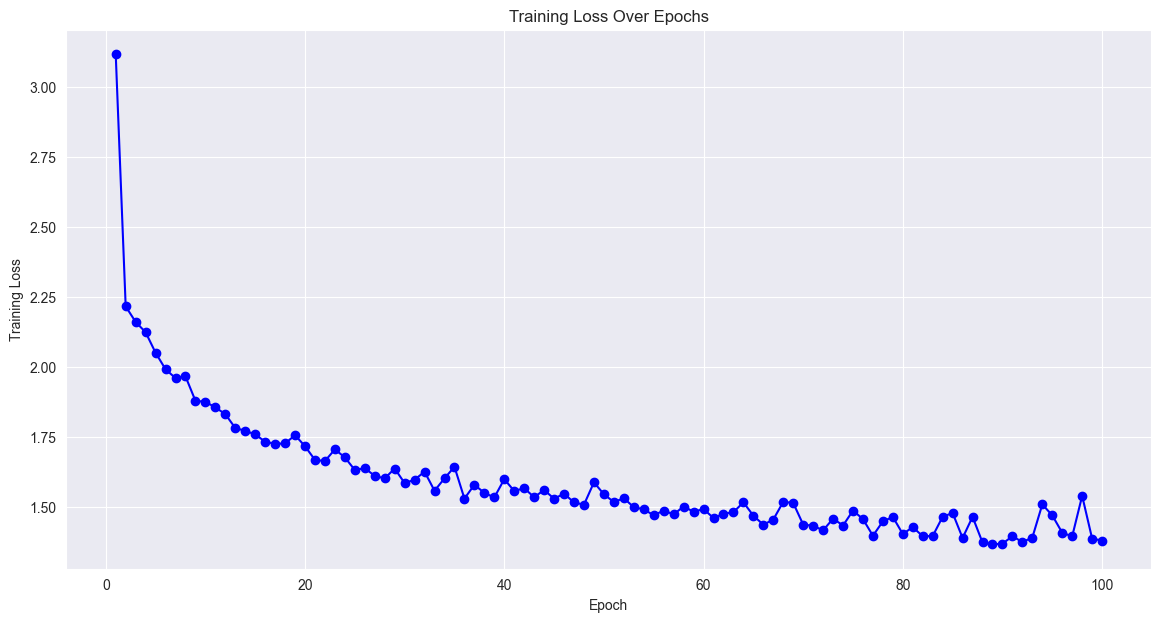

In [58]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

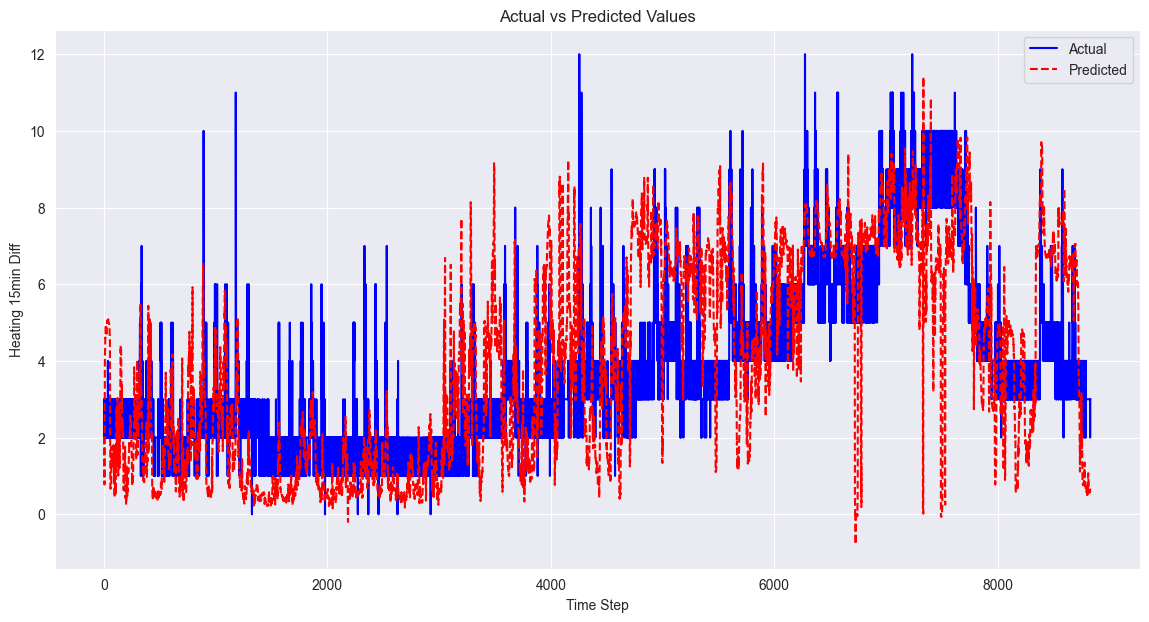

In [59]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Using indoor features


In [61]:
# Prepare the data
input_cols = [  'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'number_of_people',
       'Temperature', 'Humidity', 'Dewpoint', 'Sun Duration',
       'Precipitation Height', 'Wind Speed', 'Wind Direction',
       'indoor_temperature', 'temperature_difference']
target_col = 'heating_15min_diff'# Prepare the data

seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
batch_size = 32
input_size =  len(input_cols)  # Input feature dimension
hidden_size = 64  # LSTM hidden layer dimension
output_size = 1  # Output dimension
num_attention_heads = 4  # Number of attention heads
    
# Instantiate the model
model = TFT(input_size, hidden_size, output_size, num_attention_heads).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [63]:
train_losses = []
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        
        outputs = outputs[:, -1, :]
        
        # Reshape targets to match the output shape
        targets = targets.unsqueeze(-1)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], avg_epoch_mse_loss: {avg_epoch_loss:.4f}')

Epoch [1/100], avg_epoch_mse_loss: 3.1970
Epoch [2/100], avg_epoch_mse_loss: 2.2801
Epoch [3/100], avg_epoch_mse_loss: 2.2044
Epoch [4/100], avg_epoch_mse_loss: 2.1363
Epoch [5/100], avg_epoch_mse_loss: 2.0779
Epoch [6/100], avg_epoch_mse_loss: 2.0285
Epoch [7/100], avg_epoch_mse_loss: 2.0060
Epoch [8/100], avg_epoch_mse_loss: 1.9870
Epoch [9/100], avg_epoch_mse_loss: 1.9379
Epoch [10/100], avg_epoch_mse_loss: 1.9190
Epoch [11/100], avg_epoch_mse_loss: 1.9291
Epoch [12/100], avg_epoch_mse_loss: 1.9430
Epoch [13/100], avg_epoch_mse_loss: 1.8988
Epoch [14/100], avg_epoch_mse_loss: 1.8748
Epoch [15/100], avg_epoch_mse_loss: 1.8484
Epoch [16/100], avg_epoch_mse_loss: 1.8547
Epoch [17/100], avg_epoch_mse_loss: 1.8490
Epoch [18/100], avg_epoch_mse_loss: 1.7914
Epoch [19/100], avg_epoch_mse_loss: 1.7807
Epoch [20/100], avg_epoch_mse_loss: 1.8122
Epoch [21/100], avg_epoch_mse_loss: 1.7732
Epoch [22/100], avg_epoch_mse_loss: 1.7896
Epoch [23/100], avg_epoch_mse_loss: 1.7354
Epoch [24/100], avg_

In [64]:
# Evaluate the model
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs and targets to the same device as the model
        outputs = model(inputs).to(device)
        outputs = outputs[:, -1, :]
        loss = criterion(outputs, targets.unsqueeze(1))
        test_loss += loss.item()
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy().flatten())
    print(f'Test  mse Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RSME Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')
    
# Convert lists to numpy arrays for easier plotting
actuals = np.array(actuals)
predictions = np.array(predictions)

# Calculate MAE and R² score
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test  mse Loss: 3.5397
Test RSME Loss: 1.8814
Test MAE: 1.5572
Test R² Score: 0.2688
